<a href="https://colab.research.google.com/github/FouadX22/7168871-apprenez-les-bases-du-langage-python/blob/main/TP/TP01_MLP_vs_toy_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP01 - Training and visualizing MLPs on toy datasets

In this practical, we are going to learn how to train a simple feed forward neural network (aka Multi-Layer Perceptron or MLP) on a synthetic dataset and visualize the result. We will use a custom package to help automatically check your results.

### Auto-checker setup

In [1]:
!pip install --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import TP01
TP01.check_install()

  Cloning https://gitlab.com/robindar/dl-scaman_checker.git to /tmp/pip-req-build-zv5dbyss
  Running command git clone --filter=blob:none --quiet https://gitlab.com/robindar/dl-scaman_checker.git /tmp/pip-req-build-zv5dbyss
  Resolved https://gitlab.com/robindar/dl-scaman_checker.git to commit a7a7a553210fd343f03637eb57a370ac78d98acc
  Preparing metadata (setup.py) ... done
  Created wheel for dl-scaman-checker: filename=dl_scaman_checker-0.7.1-py3-none-any.whl size=11180 sha256=f6d937e18269611b084325094121d53cd572e24f952fd07d28fd419dacab84d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-cjsj4jdl/wheels/1c/85/09/614a6cb7ad3f91422112707afff371485479593619b3f4f5ef
Successfully built dl-scaman-checker
[DONE] Install ok. Version is v0.7.1


### Importing libraries

First import the three libraries we will use: **torch**, **numpy** (as np) and **matplotlib.pyplot** (as plt).

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

TP01.check_imports()

[DONE] Imports ok


# Part A - Checkerboard learning

## A.0 - Data generation

Then, create a function `create_checkerboard` that returns two pytorch Tensors: `X` of shape $(100,2)$ where $100$ is the number of data points and each point is drawn uniformly at random in $[-2,2]^2$, and `y` of shape $(100,2)$ where $y_i=(1,0)$ if $X_{i,1} \cdot X_{i,2} > 0$, and $y_i=(0,1)$ otherwise. The vectors $y_i$ are called **one-hot** encodings of the classes 0 and 1.

**IMPORTANT:** Always test the shape of your tensor with `print(X.shape)` to verify that your are computing the right quantity.



In [8]:
def create_checkerboard():
    X = torch.Tensor(np.random.uniform(-2,2,size=(100,2)))
    y = torch.Tensor(np.stack([X[:,0]*X[:,1] > 0, X[:,0]*X[:,1] <= 0], axis = -1))
    return X, y

In [9]:
X, y = create_checkerboard()

TP01.check_dimensions(X, y)
TP01.check_distributions(X, y)

[DONE] Dimensions ok
[DONE] Distributions ok


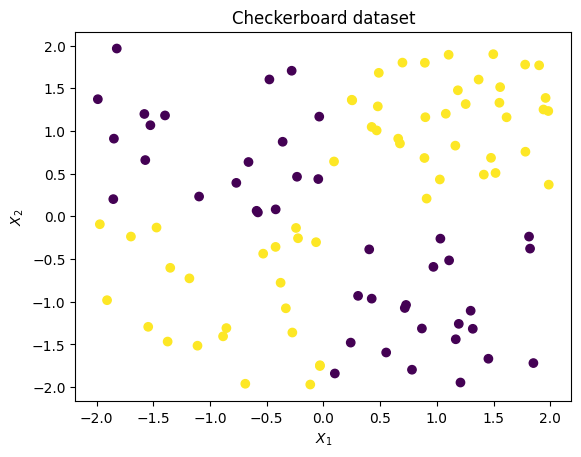

In [10]:
# Visualizing the dataset
plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Checkerboard dataset")
plt.show()

## A.1 - Model creation

First, let's create a two-layer perceptron with ReLU activations.
Create a function `create_simple_mlp(width)` that returns an MLP with 2 inputs, 2 outputs, and `width` internal neurons.
Check the documentation for `torch.nn.Sequential`, used to construct MLPs.
Since we are using linear layers and a ReLU activation, you will also need
`torch.nn.Linear` and `torch.nn.ReLU`.

In [14]:
def create_simple_mlp(width):
    model = torch.nn.Sequential(
        torch.nn.Linear(2, width),
        torch.nn.ReLU(),
        torch.nn.Linear(width,2)
        )
    return model

Using `print` and `shape`, verify that the model outputs a 2-dimensional vector for each input data point on the checkerboard dataset.

In [17]:
model = create_simple_mlp(10)
print(model(X).shape)

TP01.check_model_signature((X,y), model)

torch.Size([100, 2])
[DONE] Signature ok


## A.2 - Training pipeline

### A.2.0 - Visualizing network output

We will visualize the network output as follows. For now, the visualize function is provided. Later, you will write your own.
On the left, we plot for each point of the input plane the difference between the predicted coordinates $y_{i,0} - y_{i,1}$, positive
if the network classifies the point as class 0, and negative if it is classified as class 1.
On the right, we plot the evolution of the loss over training, given by the `losses` array. You will populate this array when writing your training loop.

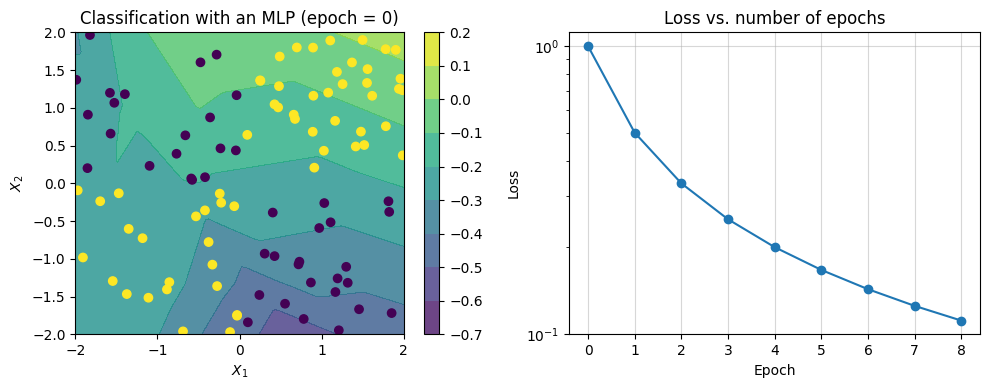

In [18]:
example_losses = [1/i for i in range(1,10)]
TP01.visualize(data=(X,y), model=model, epoch=0, losses=example_losses)

### A.2.1 - Computing gradients and modifying weights

In PyTorch, a model automatically computes the gradients with respect to a given computation whenever the `.backward()` method is called.
Here is an example of how to access the models and their parameters. After computing a value and calling `value.backward()`, the gradient of the model parameters is automatically available with the `.grad` attribute.

In [19]:
[ p.shape for p in model.parameters() ]

[torch.Size([10, 2]), torch.Size([10]), torch.Size([2, 10]), torch.Size([2])]

In [20]:
p = next(model.parameters())
print(p.grad)

None


In [26]:
value = (model(X) ** 2).mean()
value.backward()
print(p.grad)

tensor([[-0.2802, -0.5101],
        [-0.0118,  0.1284],
        [ 0.5346,  0.1768],
        [-0.8438, -0.4767],
        [-0.3050, -0.2234],
        [-0.0626,  0.0237],
        [ 0.0037,  0.0341],
        [ 0.4942,  0.4486],
        [ 0.2628,  0.1299],
        [ 0.4011,  0.5412]])


One can then reset the gradients with the method `.zero_grad()`

In [27]:
model.zero_grad()
print(p.grad)

None


### A.2.2 - Writing the gradient descent

Our objective is to push the model, for an input `X` to return an output that matches `y`. To do so we will minimize the **mean square error** $MSE = \frac{1}{N}\sum_{i=1}^N \|\mbox{model}(X_i) - y_i\|^2$ over the entire dataset using gradient descent.

Create a function `train(data, model, epochs, visualize=True)` that takes a dataset of inputs and outputs `data`, a neural network `model`, and trains the model for `epoch` epochs. For each epoch, you will need to, in order:

1. Prepare gradient computations using `model.zero_grad()`
2. Compute the output of the `model` over the input data `X`
3. Compute `loss`, the mean squared error loss over the entire dataset.
4. Use `loss.backward()` to automatically compute the gradients of the loss wrt the model parameters.
5. Make one step of gradient descent by updating the tensor `p.data` of each parameter `p` in `model.parameters()` with the formula $p = p - \eta \nabla L(p)$ where $\eta=10^{-2}$ is the step-size and $L$ is the loss. Recall that the gradient computed by `loss.backward()` is accessible in `p.grad`.
  
If `vizualize` is set to `True`, visualize the output of the neural network and loss using `TP01.visualize` once every 1000 epochs.

In [28]:
def train(data, model, epochs, visualize=True):
    X, y = data
    losses = []
    for e in range(epochs):
      model.zero_grad()
      y_train = model(X)
      loss = ((y_train - y)**2).sum()/y.shape[0]
      loss.backward()
      for p in model.parameters():
        p.data -= 0.01*p.grad
      losses.append(loss.item())
      if visualize and e % 1000 == 0:
        TP01.visualize(data, model, e, losses)
    return losses

Finally, train your MLP on the checkerboard dataset for 10000 epochs.
You should observe a decreasing loss, which reaches approximatively $6 \cdot 10^{-2}$ after 10000 epochs (the precise value varies, and depends on the random initialization, but the order of magnitude is usually similar).
You can get to lower loss values by using more training epochs.

In [ ]:
### YOUR CODE HERE ###

Is it predicting the correct classes? Does the prediction line up with the checkerboard pattern you expected ?
Try with 2, 10, and 100 neurons in the internal layer. See how the predictions change, and how close to zero the loss gets.

## A.3 - Measuring accuracy

In order to more efficiently evalute the differences observed when changing the size of the internal layer,
write an accuracy method which computes the mean accuracy of a model. Recall that for an output $y \in \mathbb{R}^2$,
we say that the model predicts 'class 0' if $y_0 > y_1$ and that it predicts 'class 1' otherwise.

In [ ]:
### YOUR CODE HERE ###

In [ ]:
acc = accuracy((X,y), model)
TP01.check_accuracy((X,y), model, acc)

## A.4 - Impact of width

Do larger models tend to perform better, the same, or worse ? Let us check the training accuracy of models as a function of the width. For each width in the list `[2, 5, 10, 20, 50, 100, 200, 1000]`, train a model of the specified width for 10,000 epochs, and record its final training accuracy. Plot the training accuracy with respect to the width with a log scale using `plt.xscale('log')`.

In [ ]:
### YOUR CODE HERE ###

### A.5 - Write your own visualization (optional)

You have been using the provided visualization code to check your model's output. Now, write your own `visualize(data, model, epoch, losses)` !

In [ ]:
### YOUR CODE HERE ###

# Part B - Harder dataset

## B.0 - Data creation

The following code create a more challenging dataset consisting of two intertwined spirals.

In [ ]:
def create_spiral():
    # Creates a spiral
    theta = np.linspace(0, 4 * np.pi, 100)
    r = np.linspace(0.5, 2, 100)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Creates another spiral for the second class
    theta = np.linspace(0, 4 * np.pi, 100)
    r = np.linspace(0.5, 2, 100) + 0.3
    x2 = r * np.cos(theta)
    y2 = r * np.sin(theta)

    # Merging both spirals into a single dataset
    X = np.vstack((np.hstack((x, x2)), np.hstack((y, y2)))).T
    y = np.hstack((np.zeros(100), np.ones(100)))

    # From numpy arrays to Pytorch tensors
    X = torch.FloatTensor(X)
    y = torch.LongTensor(np.stack([y,1-y], axis=-1))

    return X, y

# Visualizing the dataset
X, y = create_spiral()
plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Spiral dataset")
plt.show()

## B.1 - Model creation, training, validation

Train your model (don't forget to create a new model to reinitialize the parameters) on the spiral dataset for 50,000 epochs. Is it predicting the correct classes? Try increasing the number of neurons to 100 first, then more if the result does not convince you.

In [ ]:
### YOUR CODE HERE ###

## B.2 - Varying model size and training hyperparameters

Repeat the experiment with varying width, to check how the accuracy improves, or whether it does.
You can also try to increase the number of training epochs for each width.
Think about the computation time, and thus how many widths you want to try and for how long you want to train each.

In [ ]:
### YOUR CODE HERE ###

---